In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
import PolarTestingTrainingSplit_CV


# set path to model data
path_to_models = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'
ModelDataFiles = glob.glob(path_to_models)

# import the observational trend maps 
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASApplication/TASObsTrends/*.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])

# create land grid
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)


# create grid for model data
sample_grid = xr.open_dataset(ModelDataFiles[0]) 
latitudes = sample_grid.Lat.to_numpy()
longitudes = sample_grid.Lon.to_numpy() - 180
weights = np.cos(np.deg2rad(latitudes))
latbounds = [52,72]

land_sea_mask = []
for x in longitudes:
    land_sea_mask_at_latitude = []
    for y in latitudes:
        land_sea_mask_at_latitude.append(PolarTestingTrainingSplit_CV.is_land(x, y))
    land_sea_mask.append(land_sea_mask_at_latitude)
land_sea_mask = np.transpose(land_sea_mask)
land_sea_mask = np.concatenate([land_sea_mask[:,72:], land_sea_mask[:,:72]], axis=1)

# find model data global trends for all models and ensemble members
trends_array = []
for x in range(len(ModelDataFiles)):
    ModelDataFile = ModelDataFiles[x] 

    # we only need one model of testing for this CV iteration
    test_data = xr.open_dataset(ModelDataFile).to_array()[0]
    
    # reshape trends so that trend maps from different time periods and ensembles are treated equal
    NatTrends = test_data[:,0].to_numpy()[:,-1]
    ForTrends = test_data[:,1].to_numpy()[:,-1]
    TotalTrend = NatTrends + ForTrends
    
    # weight trend maps by cosine of latitude, you can use the weights from above
    TotalTrend_weighted = np.multiply(TotalTrend, weights[np.newaxis,:,np.newaxis])
    TotalTrendsTropicalMean = np.transpose(PolarTestingTrainingSplit_CV.tropical_mean_trend(TotalTrend_weighted, land_sea_mask, weights, latbounds))
    SurfaceTrends = TotalTrendsTropicalMean[:,0]

    trends_array.append(SurfaceTrends)
trends_array = np.array(trends_array)

# find model data global trends for all models and ensemble members
obsTrendlMean = np.transpose(PolarTestingTrainingSplit_CV.tropical_mean_trend(observational_trend_maps_weighted, land_sea_mask, weights, latbounds))[:,0]


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(0, 1.05)

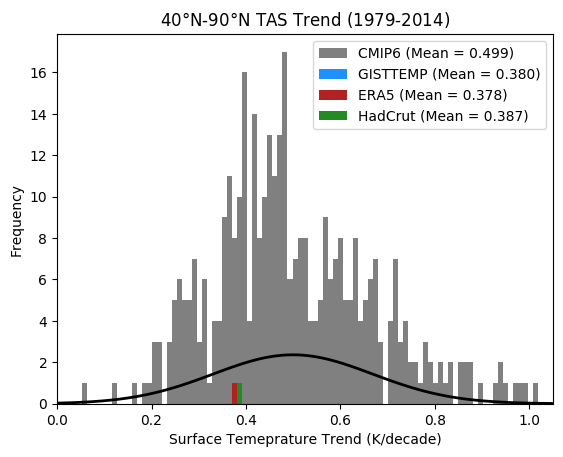

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

trends_array_flattened = []
for x in trends_array:
    for ensemble in x:
        trends_array_flattened.append(ensemble)

# Fit a normal distribution to the data:
mu, std = norm.fit(trends_array_flattened)

# Plot the PDF.
xmin = 0
xmax = 1.05
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
hist = plt.hist(trends_array_flattened, bins=x, label='CMIP6 (Mean = {ERA5})'.format(ERA5=str(mu)[:5]), color='grey')
plt.plot(x, p, 'k', linewidth=2)
title = "40$\degree$N-90$\degree$N TAS Trend (1979-2014)"
plt.title(title)
#gist = plt.hist(obsTrendlMean[0], bins=x, label='GISTTEMP (Mean = {gist})'.format(gist=str(obsTrendlMean[0])[:5]), color='dodgerblue')
#era5 = plt.hist(obsTrendlMean[1], bins=x, label='ERA5 (Mean = {ERA5})'.format(ERA5=str(obsTrendlMean[1])[:5]), color='firebrick')
#hadcrut = plt.hist(obsTrendlMean[2], bins=x, label='HadCrut (Mean = {hadcrut})'.format(hadcrut=str(obsTrendlMean[2])[:5]), color='forestgreen')
gist_NoNatural = obsTrendlMean[0] - 0.008306786948358074
era5_NoNatural = obsTrendlMean[1] - 0.0046046726399042726
hadcrut_NoNatural = obsTrendlMean[2] - 0.005794739632212896

gist = plt.hist(gist_NoNatural, bins=x, label='GISTTEMP (Mean = {gist})'.format(gist=str(gist_NoNatural)[:5]), color='dodgerblue')
era5 = plt.hist(era5_NoNatural, bins=x, label='ERA5 (Mean = {ERA5})'.format(ERA5=str(era5_NoNatural)[:5]), color='firebrick')
hadcrut = plt.hist(hadcrut_NoNatural, bins=x, label='HadCrut (Mean = {hadcrut})'.format(hadcrut=str(hadcrut_NoNatural)[:5]), color='forestgreen')

#SurfaceTrendNoNatural = GlobalERA5TrendSknTemp - -0.19088527160754348
#ERA5_NoNatural = plt.hist(SurfaceTrendNoNatural, bins=x, label='ERA5 - Natural Variability (Mean = {ERA5})'.format(ERA5=str(SurfaceTrendNoNatural[0])[:4]), color='blue')
plt.ylabel('Frequency')
plt.xlabel('Surface Temeprature Trend (K/decade)')
plt.legend()
plt.xlim(0,1.05)

In [6]:
latitudes[48:72]

array([31.25, 33.75, 36.25, 38.75, 41.25, 43.75, 46.25, 48.75, 51.25,
       53.75, 56.25, 58.75, 61.25, 63.75, 66.25, 68.75, 71.25, 73.75,
       76.25, 78.75, 81.25, 83.75, 86.25, 88.75], dtype=float32)

In [6]:
print(GlobalERA5TrendSknTemp)
SurfaceTrendNoNatural = GlobalERA5TrendSknTemp - -0.18479349720377902
print(SurfaceTrendNoNatural)

NameError: name 'GlobalERA5TrendSknTemp' is not defined

(1996, 2014)

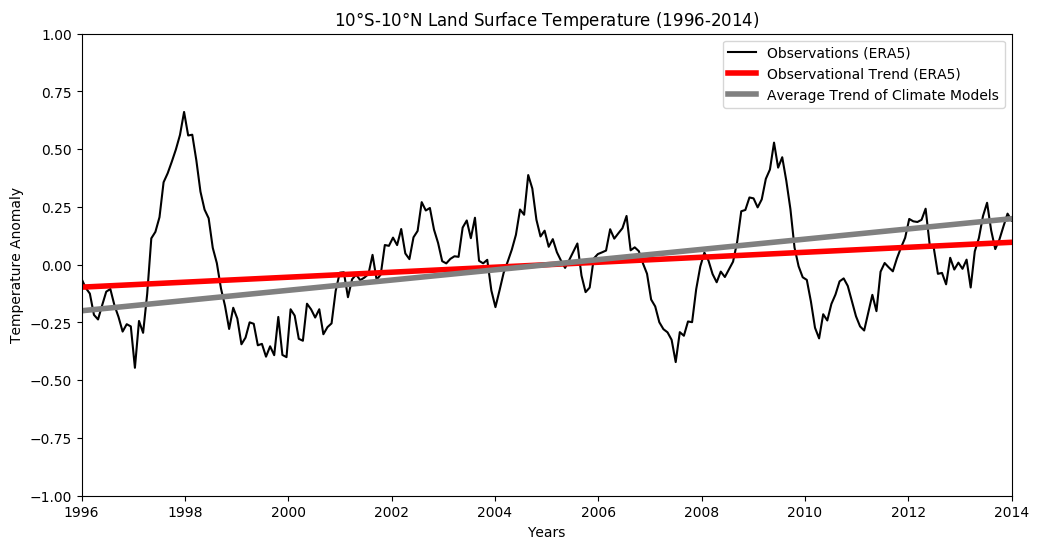

In [5]:
time = np.linspace(1996,2014,228)
plt.figure(figsize=(12,6))
plt.plot(time, ERA5_surface_land_temp_anoms_ts, label='Observations (ERA5)', color='black')
plt.plot(time, np.linspace(-.95,.95,228)*GlobalERA5TrendSknTemp, label='Observational Trend (ERA5)', color='red', linewidth=4)
plt.plot(time, np.linspace(-.95,.95,228)*mu, label='Average Trend of Climate Models', color='Grey', linewidth=4)
#plt.plot(time, np.linspace(-.95,.95,228)*SurfaceTrendNoNatural, label='Observational Trend minus Natural Variability(ERA5)', color='Blue', linewidth=2)

plt.legend()
plt.title('10$\degree$S-10$\degree$N Land Surface Temperature (1996-2014)')
plt.ylabel('Temperature Anomaly')
plt.xlabel('Years')
plt.ylim(-1,1)
plt.xlim(1996,2014)


(19, 72, 144)


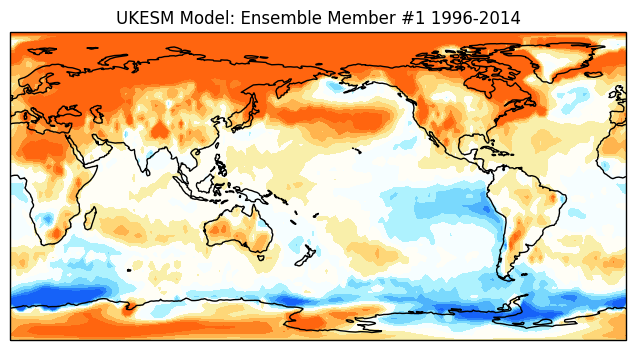

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-1.5, 1.5, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 1, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax.coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax.set_title('UKESM Model: Ensemble Member #1 1996-2014')
trend_map = np.flip(trends_ts, axis=0)
map_cyclic, lon = add_cyclic_point(trend_map, coord=lon_bins)
im = ax.contourf(lon, lat_bins, map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
print(np.shape(TotalTrend))

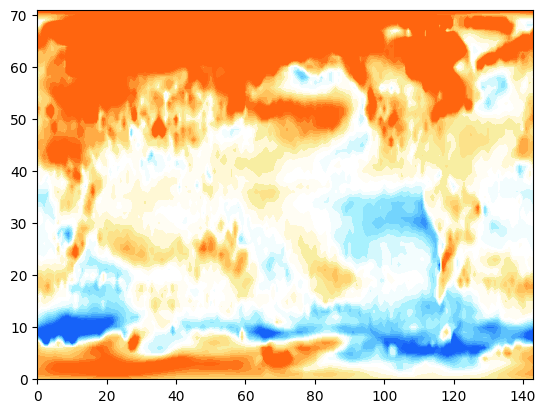

In [19]:
plt.contourf(trend_map, levels=np.linspace(-1.5,1.5,20), extend='both', cmap=custom_cmap)

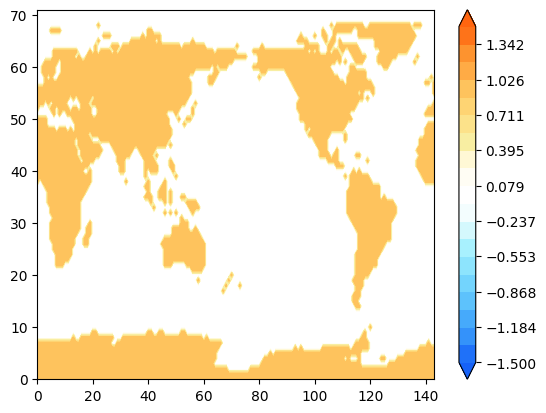

In [8]:
plt.contourf(land_sea_mask, levels=np.linspace(-1.5,1.5,20), extend='both', cmap=custom_cmap)
plt.colorbar()

(72, 144)
0.3376068036440242


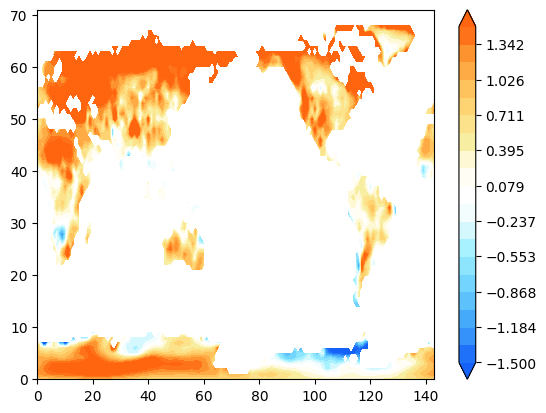

In [18]:
ocean_mask = np.abs(land_sea_mask - 1)
ocean_trends = np.ma.masked_array(data=trend_map, mask=ocean_mask, fill_value=np.nan).filled() 
print(np.shape(ocean_trends))
ocean_trend_value = np.nanmean(ocean_trends[28:44])
print(ocean_trend_value)
plt.contourf(ocean_trends, levels=np.linspace(-1.5,1.5,20), extend='both', cmap=custom_cmap)
plt.colorbar()